# About Dataset

This dataset has 17 classes.
Data are divided into three partitions: train, val and test.

Variable Information
Class Labels:
-    0 : Beet Armyworm
-    1 : Black Hairy
-    2 : Cutworm
-    3 : Field Cricket
-    4 : Jute Aphid
-    5 : Jute Hairy
-    6 : Jute Red Mite
-    7 : Jute Semilooper
-    8 : Jute Stem Girdler
-    9 : Jute Stem Weevil
-    10 : Leaf Beetle
-    11 : Mealybug
-    12 : Pod Borer
-    13 : Scopula Emissaria
-    14 : Termite
-    15 : Termite odontotermes (Rambur)
-    16 : Yellow Mite

# Import Libraries

In [ ]:
import cv2
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import time
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

# Read and Preprocessing the Dataset

Analysis for Dataset:
 - Total Images in Dataset: 7236
 - Train Set: 6444 images
 - Test Set: 379 images
 - Val Set: 413 images

Train Set Class Distribution:
   - Beet Armyworm: 199 images
   - Black Hairy: 309 images
   - Cutworm: 399 images
   - Field Cricket: 392 images
   - Jute Aphid: 531 images
   - Jute Hairy: 414 images
   - Jute Red Mite: 457 images
   - Jute Semilooper: 372 images
   - Jute Stem Girdler: 281 images
   - Jute Stem Weevil: 676 images
   - Leaf Beetle: 310 images
   - Mealybug: 466 images
   - Pod Borer: 384 images
   - Scopula Emissaria: 320 images
   - Termite: 291 images
   - Termite odontotermes (Rambur): 301 images
   - Yellow Mite: 342 images


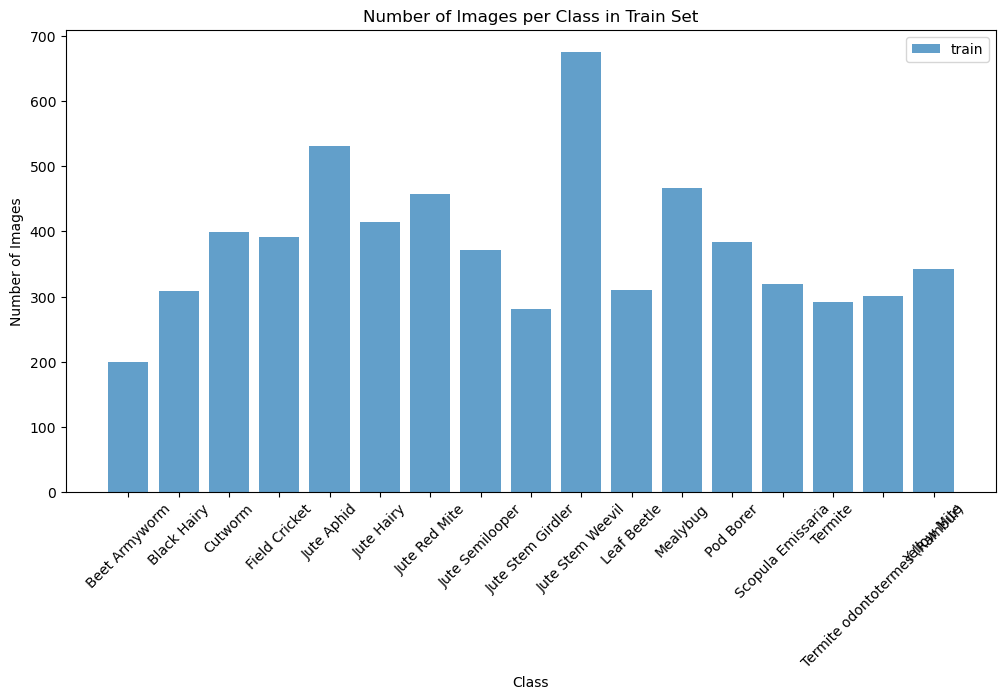

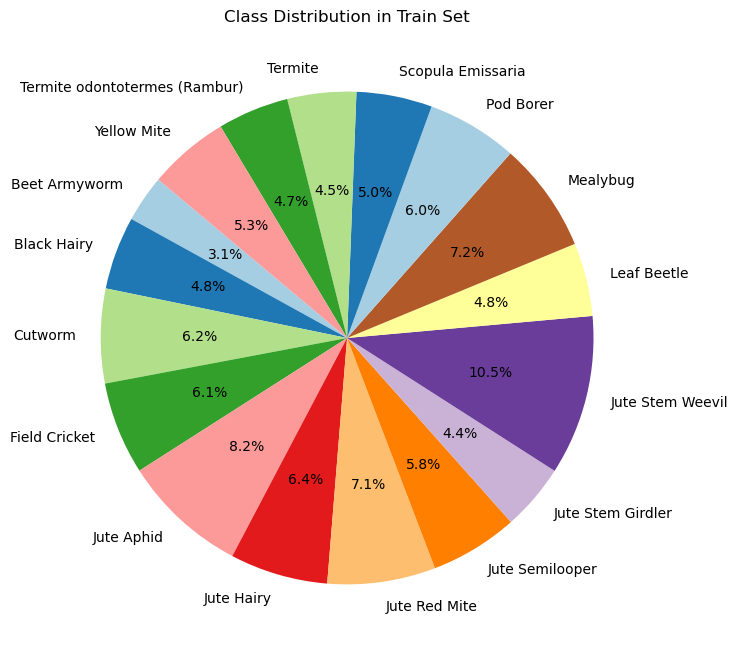


Test Set Class Distribution:
   - Beet Armyworm: 20 images
   - Black Hairy: 20 images
   - Cutworm: 20 images
   - Field Cricket: 20 images
   - Jute Aphid: 22 images
   - Jute Hairy: 20 images
   - Jute Red Mite: 24 images
   - Jute Semilooper: 21 images
   - Jute Stem Girdler: 24 images
   - Jute Stem Weevil: 24 images
   - Leaf Beetle: 24 images
   - Mealybug: 24 images
   - Pod Borer: 24 images
   - Scopula Emissaria: 24 images
   - Termite: 20 images
   - Termite odontotermes (Rambur): 24 images
   - Yellow Mite: 24 images


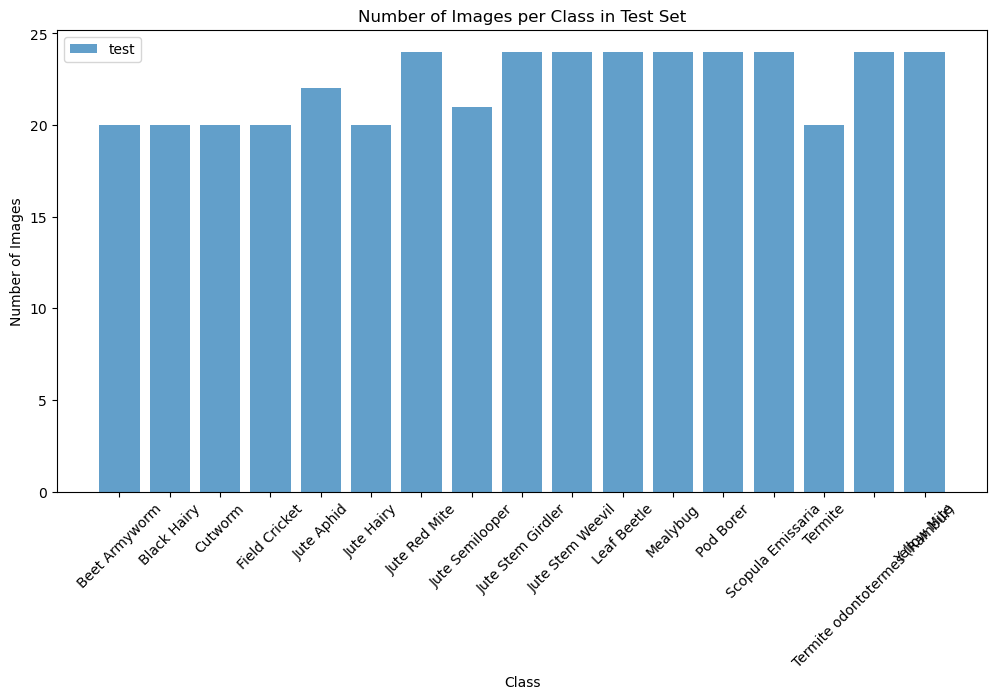

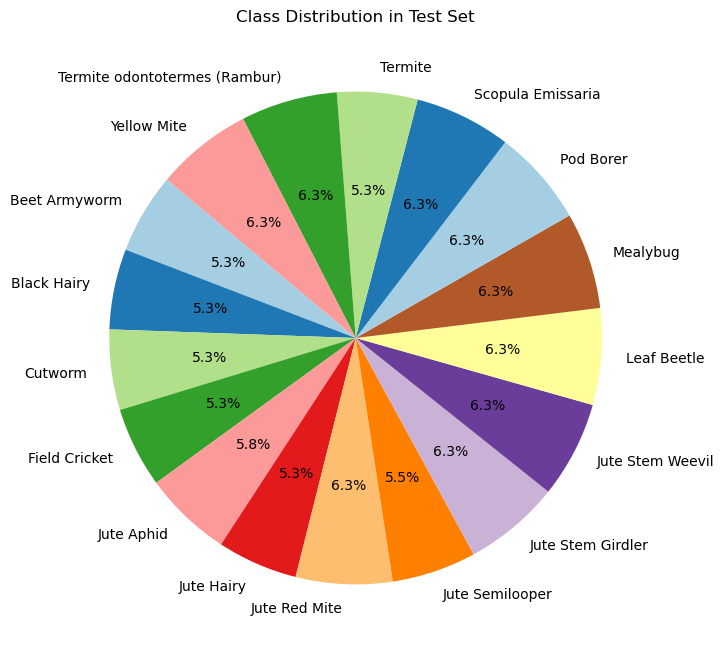


Val Set Class Distribution:
   - Beet Armyworm: 40 images
   - Black Hairy: 30 images
   - Cutworm: 18 images
   - Field Cricket: 14 images
   - Jute Aphid: 27 images
   - Jute Hairy: 8 images
   - Jute Red Mite: 49 images
   - Jute Semilooper: 5 images
   - Jute Stem Girdler: 6 images
   - Jute Stem Weevil: 71 images
   - Leaf Beetle: 9 images
   - Mealybug: 35 images
   - Pod Borer: 3 images
   - Scopula Emissaria: 6 images
   - Termite: 26 images
   - Termite odontotermes (Rambur): 36 images
   - Yellow Mite: 30 images


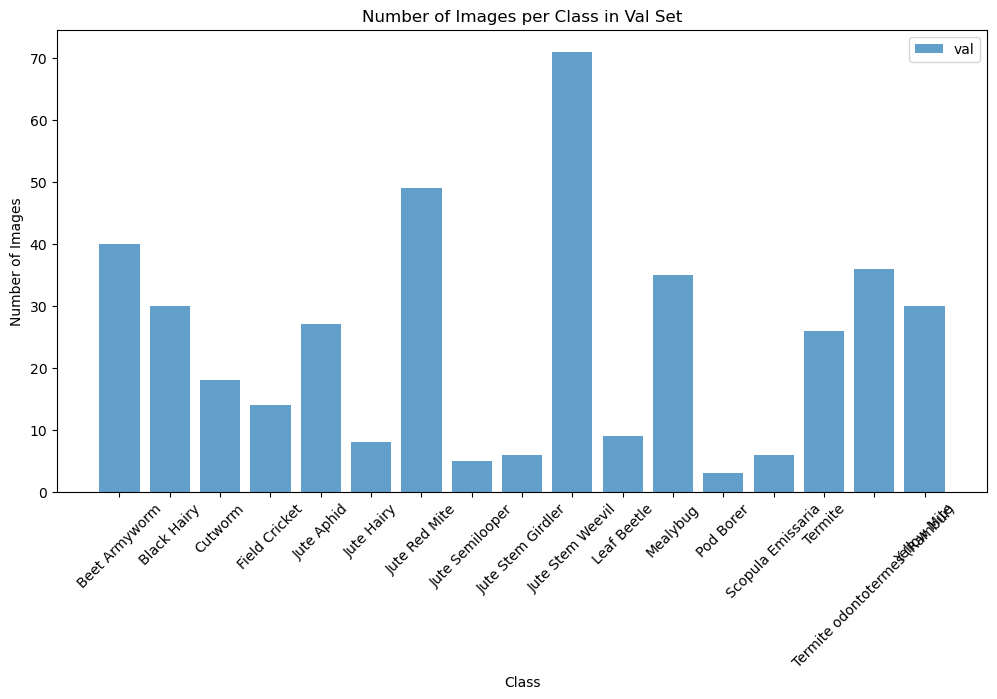

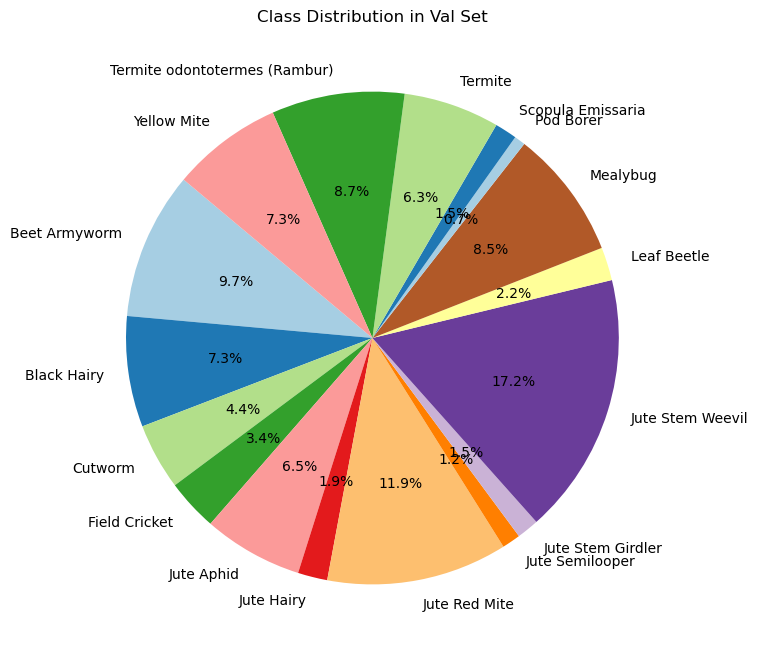


Image Properties Analysis:
All images have the same size: False
 - Image sizes: {(612, 612), (1435, 1003), (500, 444), (500, 389), (500, 334), (640, 457), (3056, 4592), (640, 640), (1016, 671), (1280, 720), (1600, 902), (170, 297), (300, 300), (800, 711), (615, 409), (800, 656), (500, 300), (200, 133), (201, 251), (800, 784), (570, 395), (1200, 800), (947, 684), (409, 307), (545, 533), (572, 526), (500, 400), (800, 622), (3116, 2180), (498, 311), (259, 194), (560, 326), (612, 461), (800, 640), (1000, 750), (103, 175), (900, 617), (550, 550), (500, 357), (365, 138), (177, 286), (768, 501), (920, 659), (267, 189), (500, 311), (500, 375), (580, 447), (800, 505), (585, 800), (164, 306), (290, 174), (1100, 775), (251, 201), (650, 401), (392, 298), (269, 188), (385, 500), (600, 400), (848, 566), (2472, 1854), (260, 194), (150, 200), (1743, 1308), (1200, 633), (1024, 791), (800, 800), (1158, 880), (800, 571), (800, 516), (450, 339), (400, 320), (690, 430), (318, 159), (768, 615), (312, 161),

In [2]:
# Path to the dataset 
dataset_path = "Jute_Pest_Dataset"
subsets = ["train", "test", "val"]  # Subfolders within dataset

# Initialize variables
image_stats = {subset: {} for subset in subsets}
total_images_per_subset = {subset: 0 for subset in subsets}
image_sizes = set()
image_modes = set()

# Helper function to analyze dataset

def analyze_folder(subset_path):
    class_counts = {}
    for class_name in sorted(os.listdir(subset_path)):  # Ensure consistent class order
        class_folder = os.path.join(subset_path, class_name)
        if os.path.isdir(class_folder):
            image_count = 0
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    with Image.open(image_path) as img:
                        image_count += 1
                        image_sizes.add(img.size)
                        image_modes.add(img.mode)
                except Exception as e:
                    print(f"Skipping invalid image {image_path}: {e}")
            class_counts[class_name] = image_count
    return class_counts

# Analyze all subsets
for subset in subsets:
    subset_path = os.path.join(dataset_path, subset)
    if os.path.exists(subset_path):
        image_stats[subset] = analyze_folder(subset_path)
        total_images_per_subset[subset] = sum(image_stats[subset].values())

# Plotting functions
def plot_bar_chart(data, title):
    plt.figure(figsize=(12, 6))
    for subset, class_counts in data.items():
        plt.bar(class_counts.keys(), class_counts.values(), label=subset, alpha=0.7)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

def plot_pie_chart(data, title):
    plt.figure(figsize=(8, 8))
    plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.show()

# Summarize and visualize results
print(f"Analysis for Dataset:")
total_images = sum(total_images_per_subset.values())
print(f" - Total Images in Dataset: {total_images}")
for subset, count in total_images_per_subset.items():
    print(f" - {subset.capitalize()} Set: {count} images")

# Per-class analysis
for subset in subsets:
    if image_stats[subset]:
        print(f"\n{subset.capitalize()} Set Class Distribution:")
        for class_name, count in image_stats[subset].items():
            print(f"   - {class_name}: {count} images")
        plot_bar_chart({subset: image_stats[subset]}, f"Number of Images per Class in {subset.capitalize()} Set")
        plot_pie_chart(image_stats[subset], f"Class Distribution in {subset.capitalize()} Set")

# Check image properties
print("\nImage Properties Analysis:")
print(f"All images have the same size: {len(image_sizes) == 1}")
if image_sizes:
    print(f" - Image sizes: {image_sizes}")
else:
    print(" - No valid images found.")

print(f"All images are Colored (RGB): {image_modes == {'RGB'}}")
print(f" - Image modes found: {image_modes}")

**Notice:** The dataset is imbalanced.

**Notice:** There was an unreadable image so i have changed it's name from E0Z0U0H040DRLQJRMQ1RLQVRYKNRYKOQ409R3KOQM0JQ70ARFKVRI0TQM0BRM0BRFK9R50FQZQJRU0Q060OR6000MQ_jpg.rf.d5626b679dd0d2f10635af64aae2a476.jpg to image1.

In [3]:

img = cv2.imread("D:\\Telegram Downloads\\Old Materials\\Fourth Year First Term\\Jute_Pest_Dataset\\train\\Jute Red Mite\\image1.jpg")
if img is None:
    print("Image is corrupt or unreadable")
else:
    print("Image is fine")

Image is fine


- I will delay Making the dataset balanced by making augmentation on minor classes in train folder and save augmented images in its folder and make all classes have the same number of images.
- **NOTICE**: When the dataset was balanced by me, the accuracy becomes smaller than the imbalanced one but not that much we can say by 2%. So I will not balance the dataset in this notebook.
- IF you want to see the version were I balanced the classes contact with me to give you this version.

## Balacing steps if want to take a hint of what i did to balace the dataset

In [4]:
# # Define your dataset path
# dataset_path = "Jute_Pest_Dataset/train"  # Replace with the actual folder containing combined images

# # List all class folders
# folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# # Count the number of images in each folder
# image_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in folders}

# # Find the maximum number of images in any folder (excluding the one with the highest count)
# max_images = max(image_counts.values())

# print(f"Image counts per folder: {image_counts}")
# print(f"Highest image count: {max_images}")

# # Define augmentation transformations (customize as needed)
# augmentations = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.Rotate(limit=25, p=0.5),
#     A.GaussNoise(p=0.3),
#     A.Resize(224, 224),
# ])

# # Function to apply augmentation and save new images
# def augment_and_save(image_path, save_folder, count):
#     image = cv2.imread(image_path)
#     if image is None:
#         print(f"Skipping corrupt image: {image_path}")
#         return
    
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     # Apply augmentation
#     augmented = augmentations(image=image)['image']
    
#     # Convert image back to BGR for OpenCV
#     augmented = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)

#     new_filename = f"aug_{count}.jpg"
#     cv2.imwrite(os.path.join(save_folder, new_filename), augmented)

# # Augment images for folders with fewer images
# for folder in tqdm(folders, desc="Augmenting folders"):
#     folder_path = os.path.join(dataset_path, folder)
#     current_count = image_counts[folder]
#     needed = max_images - current_count  # Number of images to add

#     if needed == 0:
#         continue  # Skip already balanced folder

#     images = os.listdir(folder_path)
#     num_images = len(images)

#     print(f"Augmenting {folder} with {needed} additional images...")

#     # Start augmentation from the first image in the folder
#     count = 0
#     while current_count < max_images:
#         img_index = count % num_images  # Loop over images if needed
#         img_path = os.path.join(folder_path, images[img_index])
        
#         augment_and_save(img_path, folder_path, current_count + 1)
        
#         current_count += 1
#         count += 1  # Move to the next image for augmentation

# print("Augmentation completed successfully!")

In [5]:
# # Path to the dataset (Update this if needed)
# dataset_path = "Jute_Pest_Dataset"
# subset = "train"  # Only process the train subset

# # Initialize variables
# image_stats = {}
# total_images = 0
# image_sizes = set()
# image_modes = set()

# # Helper function to analyze the train folder
# def analyze_folder(subset_path):
#     class_counts = {}
#     for class_name in sorted(os.listdir(subset_path)):  # Ensure consistent class order
#         class_folder = os.path.join(subset_path, class_name)
#         if os.path.isdir(class_folder):
#             image_count = 0
#             for image_name in os.listdir(class_folder):
#                 image_path = os.path.join(class_folder, image_name)
#                 try:
#                     with Image.open(image_path) as img:
#                         image_count += 1
#                         image_sizes.add(img.size)
#                         image_modes.add(img.mode)
#                 except Exception as e:
#                     print(f"Skipping invalid image {image_path}: {e}")
#             class_counts[class_name] = image_count
#     return class_counts

# # Analyze the train subset
# subset_path = os.path.join(dataset_path, subset)
# if os.path.exists(subset_path):
#     image_stats = analyze_folder(subset_path)
#     total_images = sum(image_stats.values())

# # Plotting functions
# def plot_bar_chart(data, title):
#     plt.figure(figsize=(12, 6))
#     plt.bar(data.keys(), data.values(), color='skyblue')
#     plt.title(title)
#     plt.xlabel("Class")
#     plt.ylabel("Number of Images")
#     plt.xticks(rotation=45)
#     plt.show()

# def plot_pie_chart(data, title):
#     plt.figure(figsize=(8, 8))
#     plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
#     plt.title(title)
#     plt.show()

# # Summarize and visualize results
# print(f"Analysis for Train Dataset:")
# print(f" - Total Images in Train Set: {total_images}")

# # Per-class analysis
# if image_stats:
#     print("\nTrain Set Class Distribution:")
#     for class_name, count in image_stats.items():
#         print(f"   - {class_name}: {count} images")
#     plot_bar_chart(image_stats, "Number of Images per Class in Train Set")
#     plot_pie_chart(image_stats, "Class Distribution in Train Set")

# # Check image properties
# print("\nImage Properties Analysis:")
# print(f"All images have the same size: {len(image_sizes) == 1}")
# if image_sizes:
#     print(f" - Image sizes: {image_sizes}")
# else:
#     print(" - No valid images found.")

# print(f"All images are Colored (RGB): {image_modes == {'RGB'}}")
# print(f" - Image modes found: {image_modes}")

I prefered writing the code of DATA PREPROCESSING when building the model to make it easy for me to edit it as i want with every model version.

# Build and Train the Model

### Using ResNet18

Epoch [1/50], Time: 36.01s, Train Loss: 0.8184, Train Acc: 75.42%, Val Loss: 1.4765, Val Acc: 58.35%
Epoch [2/50], Time: 38.24s, Train Loss: 0.3833, Train Acc: 88.31%, Val Loss: 0.9927, Val Acc: 75.54%
Epoch [3/50], Time: 38.23s, Train Loss: 0.3270, Train Acc: 90.10%, Val Loss: 1.1279, Val Acc: 70.46%
Epoch [4/50], Time: 36.59s, Train Loss: 0.2425, Train Acc: 92.44%, Val Loss: 0.8436, Val Acc: 76.76%
Epoch [5/50], Time: 35.87s, Train Loss: 0.1735, Train Acc: 94.58%, Val Loss: 1.0038, Val Acc: 76.27%
Epoch [6/50], Time: 36.22s, Train Loss: 0.2009, Train Acc: 93.47%, Val Loss: 0.6609, Val Acc: 87.41%
Epoch [7/50], Time: 37.19s, Train Loss: 0.1166, Train Acc: 96.48%, Val Loss: 1.0553, Val Acc: 81.60%
Epoch [8/50], Time: 35.89s, Train Loss: 0.1779, Train Acc: 94.46%, Val Loss: 0.8790, Val Acc: 83.54%
Epoch [9/50], Time: 35.73s, Train Loss: 0.1478, Train Acc: 95.55%, Val Loss: 0.9615, Val Acc: 82.08%
Epoch [10/50], Time: 35.58s, Train Loss: 0.1036, Train Acc: 96.88%, Val Loss: 0.6921, Val A

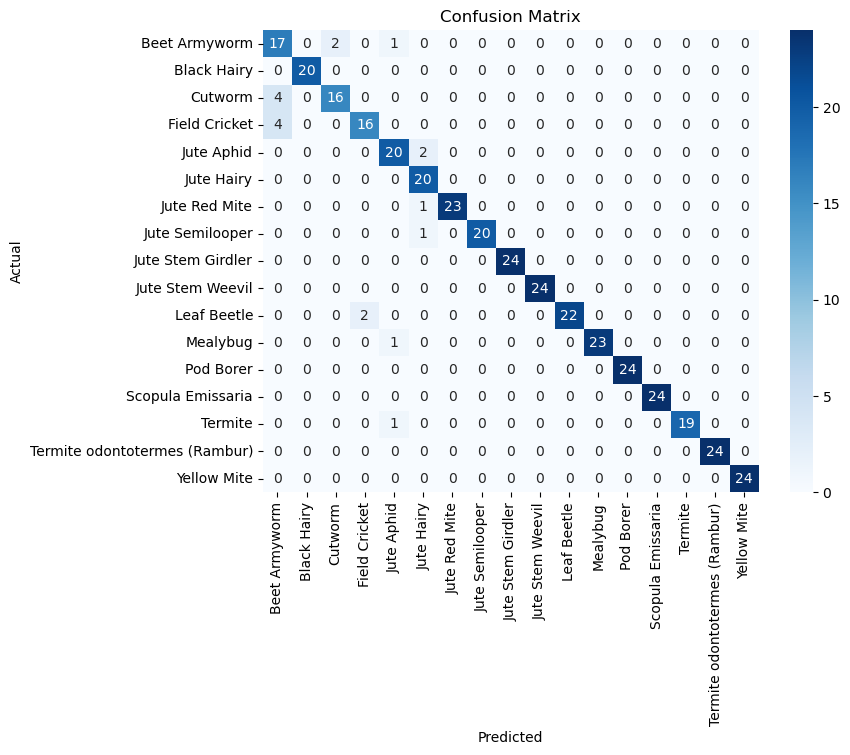

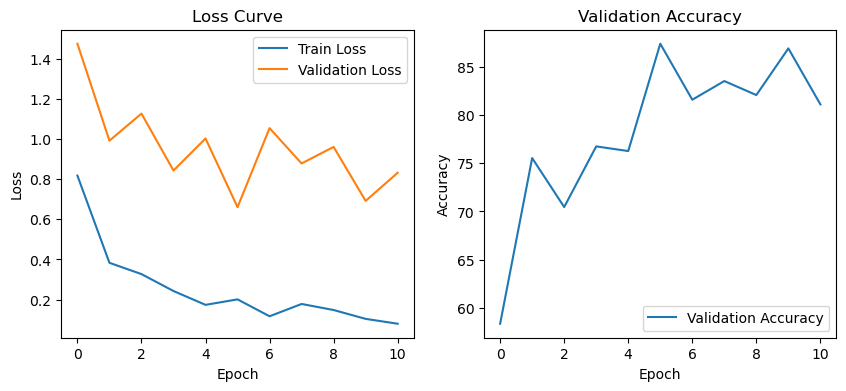

In [6]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)  # Number of classes in dataset

# Use a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Stop if validation loss doesn't improve after 5 epochs
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/1.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/1.pth"))  # Load best model
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

### Building Models From Scratch to reach the best structure

Epoch [1/50], Time: 35.44s, Train Loss: 2.8332, Train Acc: 13.16%, Val Loss: 2.4749, Val Acc: 21.07%
Epoch [2/50], Time: 34.22s, Train Loss: 2.5645, Train Acc: 15.95%, Val Loss: 2.3162, Val Acc: 30.27%
Epoch [3/50], Time: 34.27s, Train Loss: 2.4856, Train Acc: 18.13%, Val Loss: 2.2517, Val Acc: 34.14%
Epoch [4/50], Time: 34.04s, Train Loss: 2.4360, Train Acc: 18.90%, Val Loss: 2.1298, Val Acc: 30.51%
Epoch [5/50], Time: 34.18s, Train Loss: 2.4048, Train Acc: 20.53%, Val Loss: 2.2209, Val Acc: 35.11%
Epoch [6/50], Time: 34.99s, Train Loss: 2.3348, Train Acc: 21.65%, Val Loss: 2.0623, Val Acc: 39.71%
Epoch [7/50], Time: 35.24s, Train Loss: 2.2980, Train Acc: 22.45%, Val Loss: 2.0107, Val Acc: 39.71%
Epoch [8/50], Time: 33.96s, Train Loss: 2.2792, Train Acc: 24.10%, Val Loss: 2.0658, Val Acc: 34.38%
Epoch [9/50], Time: 33.81s, Train Loss: 2.2482, Train Acc: 24.72%, Val Loss: 1.8928, Val Acc: 41.16%
Epoch [10/50], Time: 33.95s, Train Loss: 2.2184, Train Acc: 25.64%, Val Loss: 1.8951, Val A

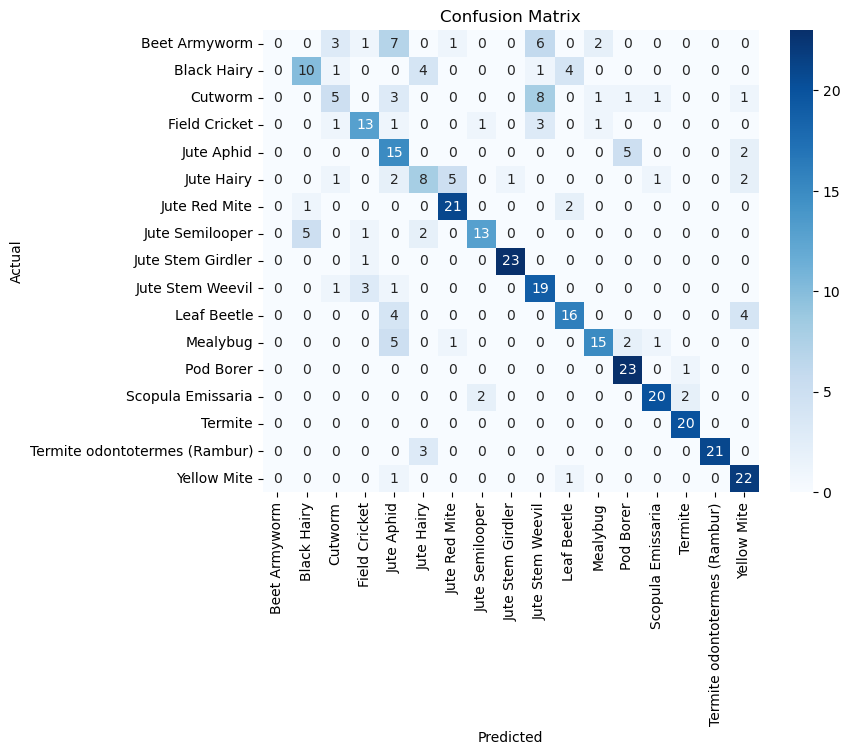

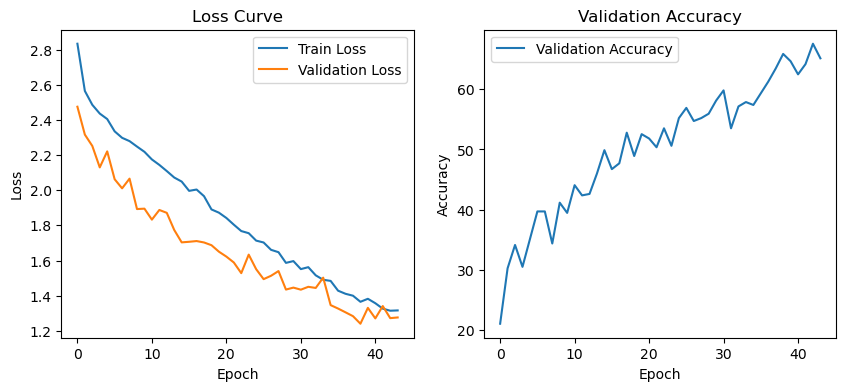

In [7]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = x.view( -1, 5 * 5 * 512)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/2.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/2.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Epoch [1/50], Time: 34.79s, Train Loss: 2.2380, Train Acc: 28.62%, Val Loss: 1.7528, Val Acc: 46.73%
Epoch [2/50], Time: 34.77s, Train Loss: 1.7465, Train Acc: 44.23%, Val Loss: 1.9161, Val Acc: 38.74%
Epoch [3/50], Time: 35.73s, Train Loss: 1.4588, Train Acc: 53.40%, Val Loss: 1.5225, Val Acc: 55.93%
Epoch [4/50], Time: 36.05s, Train Loss: 1.2522, Train Acc: 60.74%, Val Loss: 1.5267, Val Acc: 53.51%
Epoch [5/50], Time: 35.67s, Train Loss: 1.0567, Train Acc: 66.59%, Val Loss: 1.4330, Val Acc: 58.11%
Epoch [6/50], Time: 35.34s, Train Loss: 0.9311, Train Acc: 70.93%, Val Loss: 1.5052, Val Acc: 58.11%
Epoch [7/50], Time: 35.00s, Train Loss: 0.7966, Train Acc: 74.60%, Val Loss: 1.4357, Val Acc: 61.02%
Epoch [8/50], Time: 35.03s, Train Loss: 0.7058, Train Acc: 77.79%, Val Loss: 1.5487, Val Acc: 60.05%
Epoch [9/50], Time: 34.99s, Train Loss: 0.6407, Train Acc: 79.97%, Val Loss: 1.3036, Val Acc: 69.25%
Epoch [10/50], Time: 35.79s, Train Loss: 0.5674, Train Acc: 82.00%, Val Loss: 1.2656, Val A

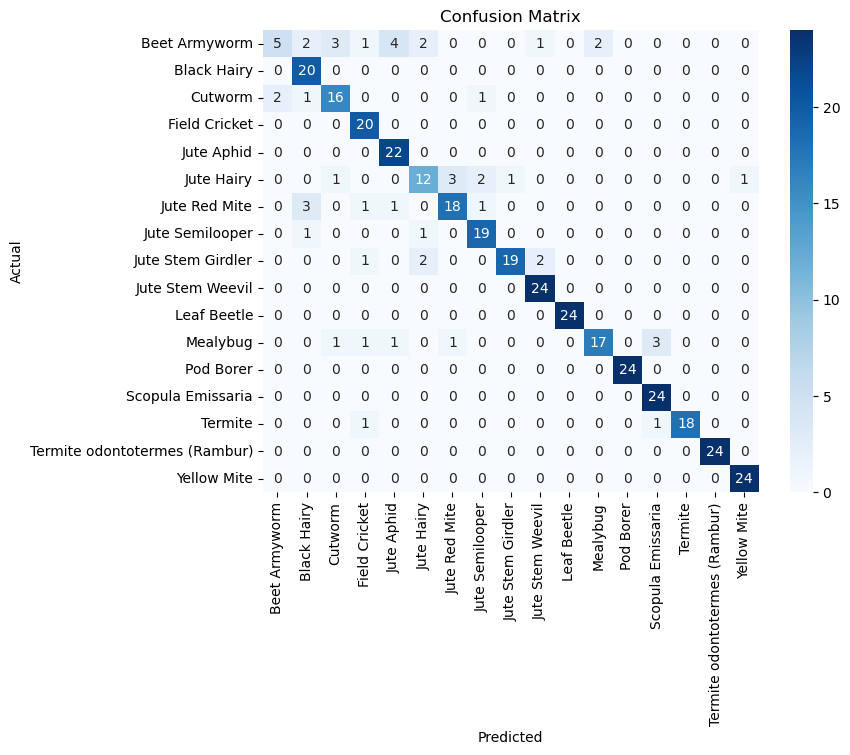

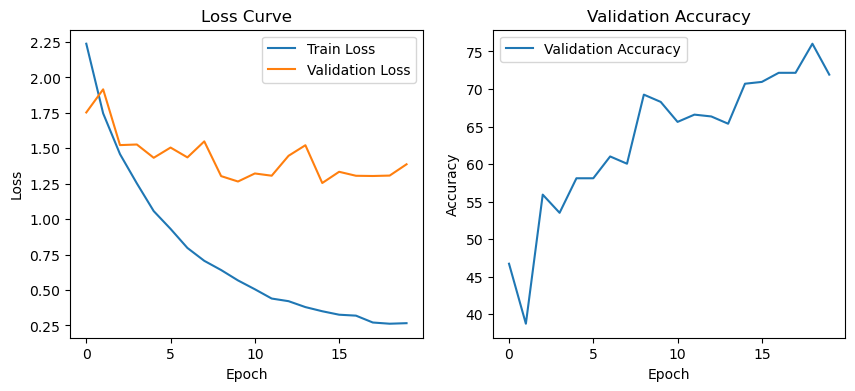

In [8]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view( -1, 1 * 1 * 1024)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/3.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/3.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Epoch [1/50], Time: 33.72s, Train Loss: 2.4391, Train Acc: 23.06%, Val Loss: 2.0461, Val Acc: 39.95%
Epoch [2/50], Time: 33.55s, Train Loss: 2.0212, Train Acc: 35.29%, Val Loss: 1.7650, Val Acc: 45.04%
Epoch [3/50], Time: 33.50s, Train Loss: 1.8066, Train Acc: 42.63%, Val Loss: 1.6519, Val Acc: 52.30%
Epoch [4/50], Time: 33.29s, Train Loss: 1.6557, Train Acc: 46.77%, Val Loss: 1.7908, Val Acc: 45.28%
Epoch [5/50], Time: 34.36s, Train Loss: 1.5337, Train Acc: 50.45%, Val Loss: 1.5740, Val Acc: 53.03%
Epoch [6/50], Time: 35.19s, Train Loss: 1.4153, Train Acc: 53.74%, Val Loss: 1.5533, Val Acc: 52.30%
Epoch [7/50], Time: 34.82s, Train Loss: 1.3538, Train Acc: 56.53%, Val Loss: 1.4986, Val Acc: 59.08%
Epoch [8/50], Time: 34.54s, Train Loss: 1.2475, Train Acc: 60.32%, Val Loss: 1.6166, Val Acc: 53.51%
Epoch [9/50], Time: 33.59s, Train Loss: 1.1789, Train Acc: 62.20%, Val Loss: 1.4245, Val Acc: 58.35%
Epoch [10/50], Time: 33.55s, Train Loss: 1.0545, Train Acc: 66.43%, Val Loss: 1.4952, Val A

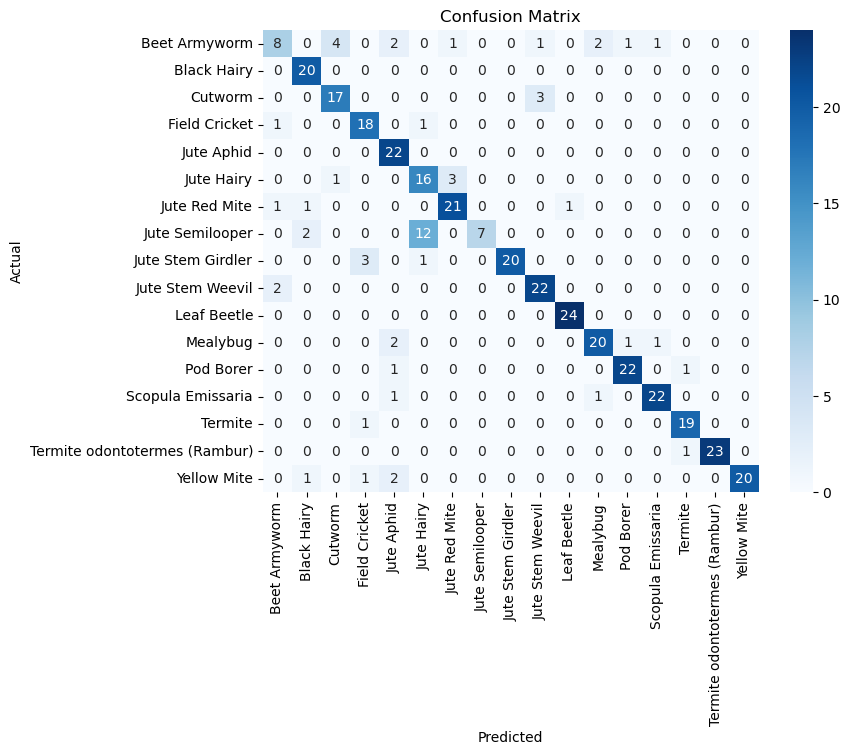

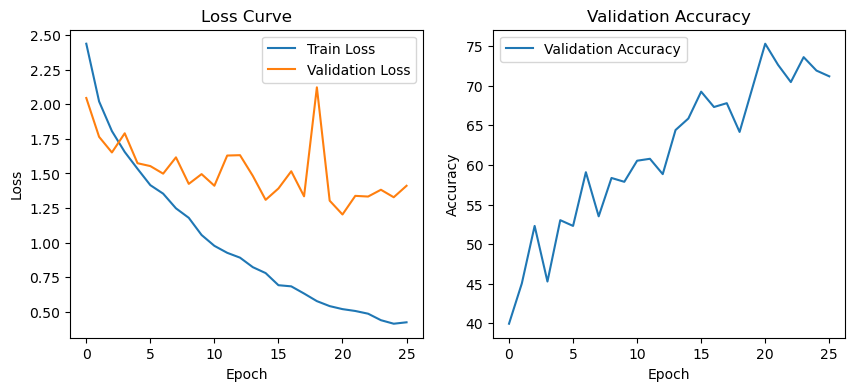

In [9]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view( -1, 2 * 2 * 1024)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/4.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/4.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Epoch [1/50], Time: 40.43s, Train Loss: 2.2248, Train Acc: 29.14%, Val Loss: 2.0493, Val Acc: 39.71%
Epoch [2/50], Time: 40.81s, Train Loss: 1.7392, Train Acc: 44.97%, Val Loss: 1.7227, Val Acc: 46.25%
Epoch [3/50], Time: 39.84s, Train Loss: 1.4605, Train Acc: 53.31%, Val Loss: 1.5621, Val Acc: 55.45%
Epoch [4/50], Time: 40.48s, Train Loss: 1.2796, Train Acc: 59.22%, Val Loss: 1.6473, Val Acc: 52.30%
Epoch [5/50], Time: 39.93s, Train Loss: 1.0964, Train Acc: 65.22%, Val Loss: 1.4821, Val Acc: 59.32%
Epoch [6/50], Time: 37.19s, Train Loss: 0.9628, Train Acc: 70.08%, Val Loss: 1.4602, Val Acc: 59.08%
Epoch [7/50], Time: 37.14s, Train Loss: 0.8325, Train Acc: 73.70%, Val Loss: 1.2858, Val Acc: 65.13%
Epoch [8/50], Time: 37.22s, Train Loss: 0.7749, Train Acc: 76.01%, Val Loss: 1.4125, Val Acc: 63.68%
Epoch [9/50], Time: 37.15s, Train Loss: 0.6960, Train Acc: 78.48%, Val Loss: 1.3757, Val Acc: 62.23%
Epoch [10/50], Time: 37.05s, Train Loss: 0.6102, Train Acc: 80.90%, Val Loss: 1.3479, Val A

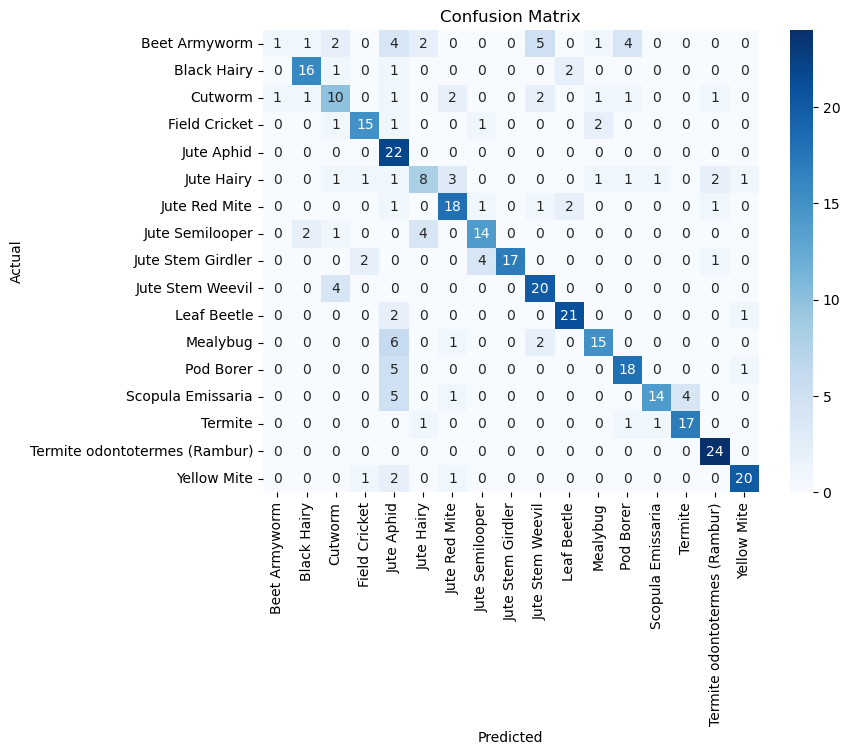

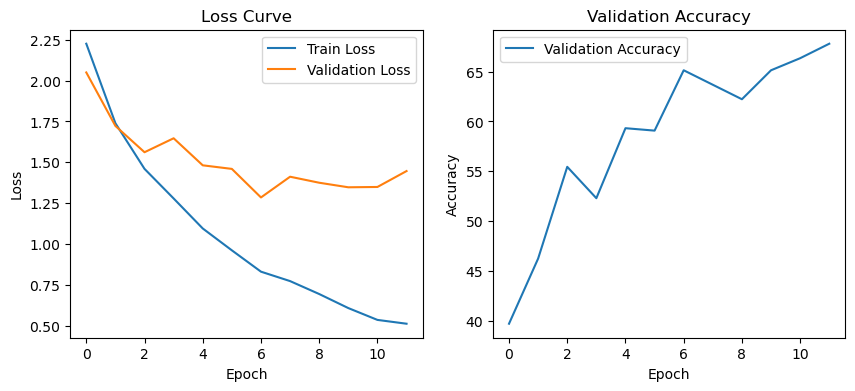

In [10]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view( -1, 1 * 1 * 1024)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/5.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/5.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Epoch [1/50], Time: 35.12s, Train Loss: 2.3110, Train Acc: 26.38%, Val Loss: 1.8909, Val Acc: 46.49%
Epoch [2/50], Time: 35.00s, Train Loss: 1.9319, Train Acc: 38.47%, Val Loss: 1.8125, Val Acc: 39.23%
Epoch [3/50], Time: 36.02s, Train Loss: 1.6630, Train Acc: 47.25%, Val Loss: 1.7858, Val Acc: 48.43%
Epoch [4/50], Time: 36.54s, Train Loss: 1.4711, Train Acc: 52.72%, Val Loss: 1.3762, Val Acc: 59.81%
Epoch [5/50], Time: 36.45s, Train Loss: 1.3474, Train Acc: 56.95%, Val Loss: 1.3858, Val Acc: 58.11%
Epoch [6/50], Time: 36.29s, Train Loss: 1.1826, Train Acc: 62.34%, Val Loss: 1.4464, Val Acc: 60.53%
Epoch [7/50], Time: 36.48s, Train Loss: 1.0716, Train Acc: 66.15%, Val Loss: 1.3275, Val Acc: 58.35%
Epoch [8/50], Time: 36.44s, Train Loss: 0.9453, Train Acc: 69.79%, Val Loss: 1.2808, Val Acc: 59.56%
Epoch [9/50], Time: 36.15s, Train Loss: 0.8814, Train Acc: 72.35%, Val Loss: 1.2309, Val Acc: 63.68%
Epoch [10/50], Time: 36.49s, Train Loss: 0.8104, Train Acc: 74.12%, Val Loss: 1.3027, Val A

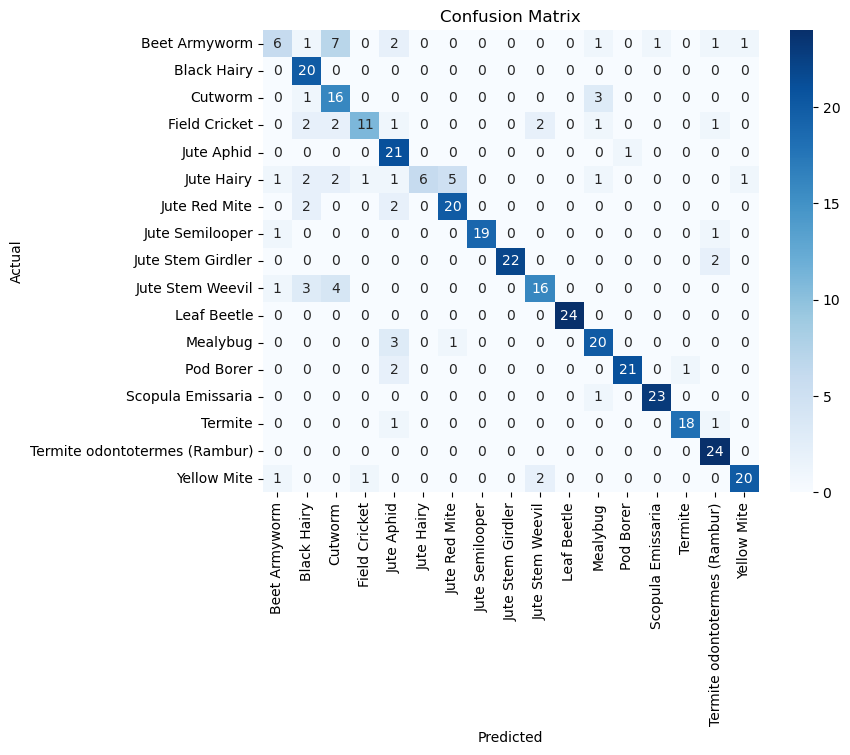

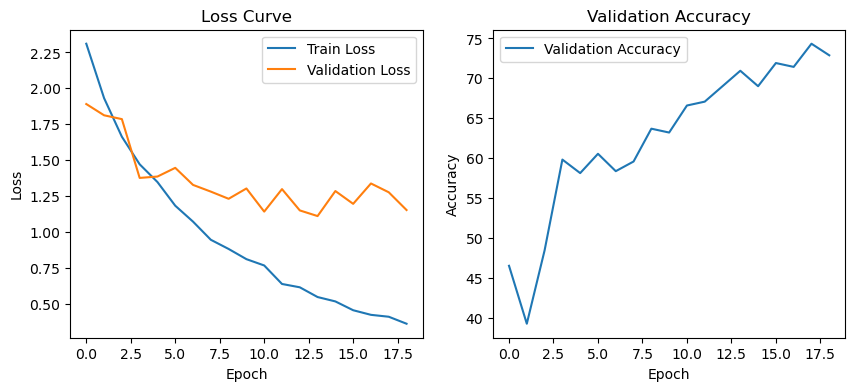

In [11]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view( -1, 1 * 1 * 1024)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/6.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/6.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

### Load pre-trained ResNet18 and modify final layer

Epoch [1/50], Time: 31.94s, Train Loss: 1.3389, Train Acc: 60.02%, Val Loss: 1.1325, Val Acc: 66.10%
Epoch [2/50], Time: 31.54s, Train Loss: 0.8514, Train Acc: 73.79%, Val Loss: 2.6268, Val Acc: 53.03%
Epoch [3/50], Time: 31.52s, Train Loss: 0.6713, Train Acc: 79.30%, Val Loss: 1.3581, Val Acc: 72.15%
Epoch [4/50], Time: 31.57s, Train Loss: 0.6610, Train Acc: 79.45%, Val Loss: 1.0485, Val Acc: 76.51%
Epoch [5/50], Time: 31.65s, Train Loss: 0.5514, Train Acc: 82.77%, Val Loss: 1.6254, Val Acc: 70.94%
Epoch [6/50], Time: 31.73s, Train Loss: 0.4869, Train Acc: 84.79%, Val Loss: 0.7830, Val Acc: 79.42%
Epoch [7/50], Time: 31.44s, Train Loss: 0.4199, Train Acc: 87.15%, Val Loss: 0.8008, Val Acc: 82.08%
Epoch [8/50], Time: 34.32s, Train Loss: 0.3853, Train Acc: 87.79%, Val Loss: 0.7104, Val Acc: 84.75%
Epoch [9/50], Time: 33.37s, Train Loss: 0.4012, Train Acc: 87.85%, Val Loss: 0.7713, Val Acc: 82.08%
Epoch [10/50], Time: 34.33s, Train Loss: 0.3887, Train Acc: 88.24%, Val Loss: 0.9034, Val A

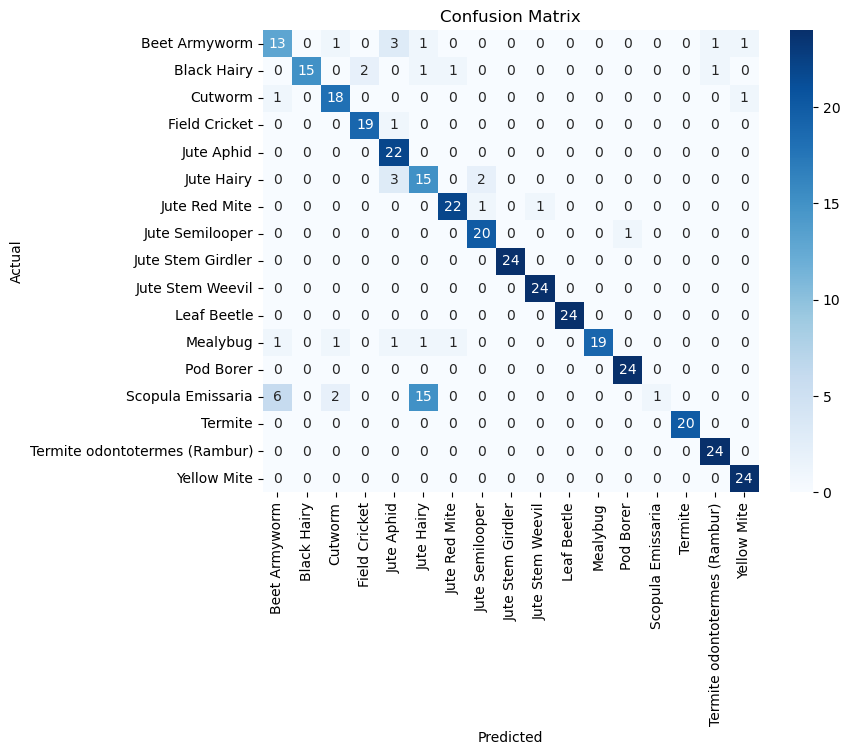

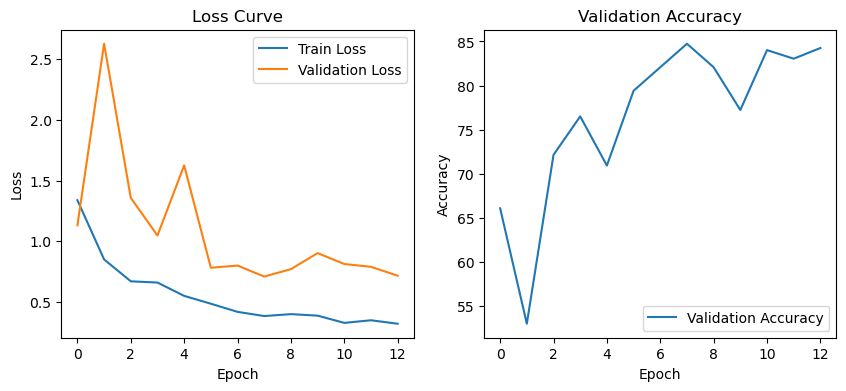

In [12]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations for training and validation with ResNet-appropriate normalization
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path

# Load datasets from separate train, validation, and test folders
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL CREATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Load pre-trained ResNet18 and modify final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

# === STEP 3: TRAINING LOOP ===
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {end_time - start_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Models/7.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === STEP 4: TESTING & CONFUSION MATRIX ===
model.load_state_dict(torch.load("Models/7.pth"))
model.eval()
test_correct = 0
test_total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === STEP 5: PLOTTING LOSS & ACCURACY ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

### Ensemble Model 1(Resnet18) and Model 3(From Scratch)


Ensemble Test Accuracy: 97.10%

Classification Report:

                               precision    recall  f1-score   support

                Beet Armyworm       0.83      0.75      0.79        20
                  Black Hairy       0.91      1.00      0.95        20
                      Cutworm       0.89      0.85      0.87        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.88      1.00      0.94        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
                     Mealybug       1.00      0.96      0.98        24
                   

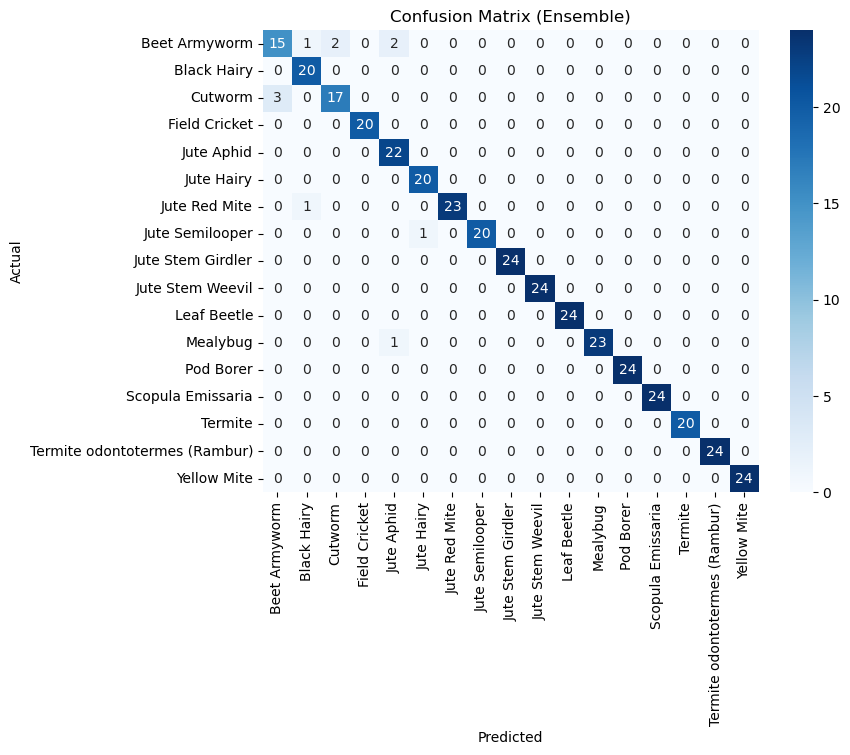

In [13]:
# === STEP 1: DATA PREPROCESSING ===
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL DEFINITIONS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Custom CNN Model (corrected to output raw logits)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 1024 * 1 * 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Raw logits

# ResNet18 Model
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Instantiate models
custom_model = CustomCNN(num_classes).to(device)
resnet_model = resnet_model.to(device)

# === STEP 4: ENSEMBLE TESTING ===
custom_model.load_state_dict(torch.load("Models/3.pth"))
resnet_model.load_state_dict(torch.load("Models/1.pth"))
custom_model.eval()
resnet_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs_custom = custom_model(images)
        outputs_resnet = resnet_model(images)
        probs_custom = F.softmax(outputs_custom, dim=1)
        probs_resnet = F.softmax(outputs_resnet, dim=1)
        avg_probs = (probs_custom + probs_resnet) / 2
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nEnsemble Test Accuracy: {test_acc:.2f}%")

class_names = train_dataset.classes
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ensemble)")
plt.show()

### Ensemble Model 1(Resnet18) and Model 7(edited ResNet18 last layer)


Ensemble Test Accuracy: 80.21%

Classification Report:

                               precision    recall  f1-score   support

                Beet Armyworm       0.52      0.60      0.56        20
                  Black Hairy       1.00      0.70      0.82        20
                      Cutworm       0.94      0.80      0.86        20
                Field Cricket       1.00      0.60      0.75        20
                   Jute Aphid       0.84      0.95      0.89        22
                   Jute Hairy       0.31      1.00      0.48        20
                Jute Red Mite       1.00      0.79      0.88        24
              Jute Semilooper       0.94      0.71      0.81        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       0.96      0.92      0.94        24
                  Leaf Beetle       0.96      0.96      0.96        24
                     Mealybug       0.82      0.96      0.88        24
                   

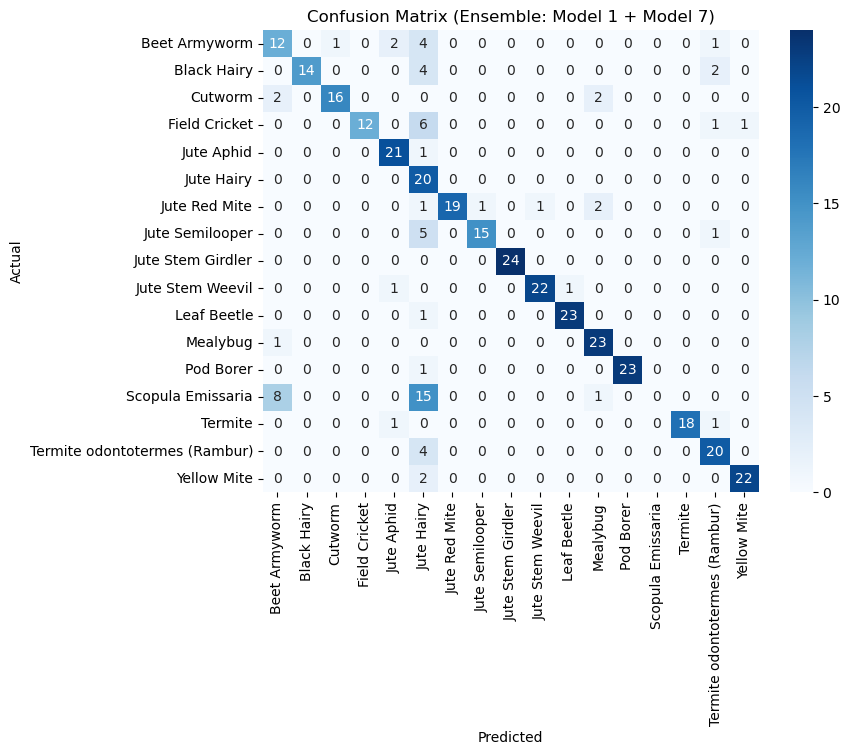

In [14]:
# === STEP 1: DATA PREPROCESSING ===
# Define transformations (using ImageNet normalization for ResNet compatibility)
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = "Jute_Pest_Dataset"  # Adjust to your dataset path
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL DEFINITIONS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Model 1: ResNet18 fine-tuned from pre-trained weights
model1 = models.resnet18(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, num_classes)
model1.load_state_dict(torch.load("Models/1.pth"))
model1 = model1.to(device)
model1.eval()

# Model 7: ResNet18 trained from scratch
model7 = models.resnet18(pretrained=False)
model7.fc = nn.Linear(model7.fc.in_features, num_classes)
model7.load_state_dict(torch.load("Models/7.pth"))
model7 = model7.to(device)
model7.eval()

# === STEP 3: ENSEMBLE TESTING ===
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs1 = model1(images)
        outputs7 = model7(images)
        probs1 = F.softmax(outputs1, dim=1)
        probs7 = F.softmax(outputs7, dim=1)
        avg_probs = (probs1 + probs7) / 2
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nEnsemble Test Accuracy: {test_acc:.2f}%")

# Class names for reporting
class_names = test_dataset.classes

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ensemble: Model 1 + Model 7)")
plt.show()

### Ensemble Model 3(From Scratch) and Model 7(edited ResNet18 last layer)


Ensemble Test Accuracy: 89.45%


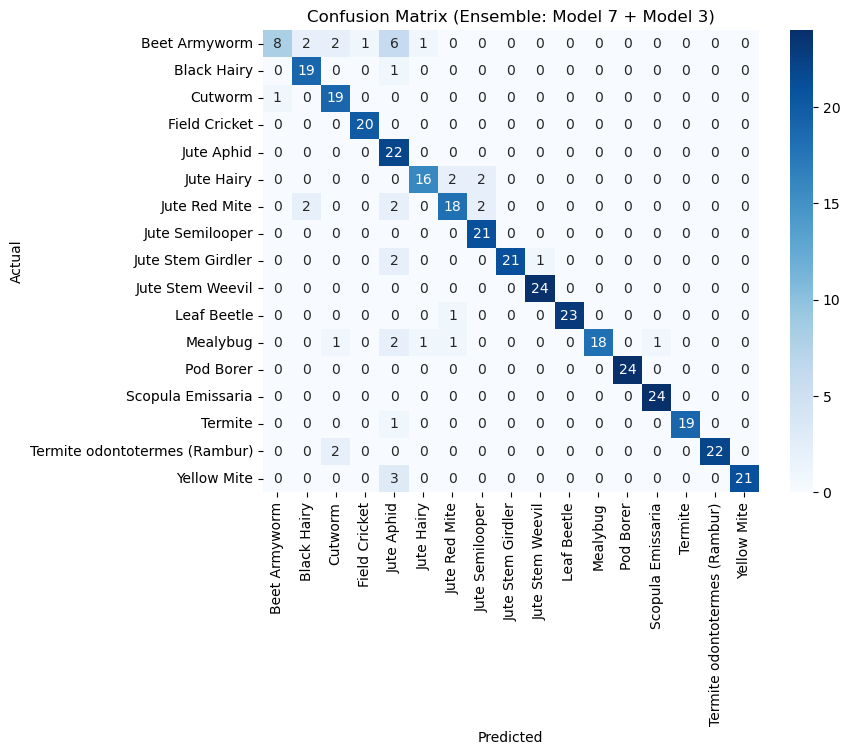

In [15]:
# === STEP 1: DATA PREPROCESSING ===
# Define test transformations (consistent with training)
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Adjust to your dataset path
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# === STEP 2: MODEL DEFINITIONS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(test_dataset.classes)

# Define the CustomCNN class (Model 3) as in your code
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 1024 * 1 * 1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Raw logits (note: your original returns log_softmax, but we'll use logits here)

# Load Model 7: ResNet18 trained from scratch
model7 = models.resnet18(pretrained=False)
model7.fc = nn.Linear(model7.fc.in_features, num_classes)
model7.load_state_dict(torch.load("Models/7.pth"))
model7 = model7.to(device)
model7.eval()

# Load Model 3: Custom CNN
model3 = CustomCNN(num_classes)
model3.load_state_dict(torch.load("Models/3.pth"))
model3 = model3.to(device)
model3.eval()

# === STEP 3: ENSEMBLE TESTING ===
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Get predictions from both models
        outputs7 = model7(images)
        outputs3 = model3(images)
        # Convert logits to probabilities
        probs7 = F.softmax(outputs7, dim=1)
        probs3 = F.softmax(outputs3, dim=1)
        # Average the probabilities
        avg_probs = (probs7 + probs3) / 2
        # Get the predicted class
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nEnsemble Test Accuracy: {test_acc:.2f}%")

# === STEP 4: PLOT CONFUSION MATRIX ===
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ensemble: Model 7 + Model 3)")
plt.show()

### Saving and Using the Ensemble(Model 1&3) as a Single Model

#### Define the Ensemble Model Class

In [16]:
class EnsembleModel(nn.Module):
    def __init__(self, custom_model, resnet_model):
        super(EnsembleModel, self).__init__()
        self.custom_model = custom_model
        self.resnet_model = resnet_model

    def forward(self, x):
        # Get raw logits from both models
        outputs_custom = self.custom_model(x)
        outputs_resnet = self.resnet_model(x)
        # Compute softmax probabilities
        probs_custom = F.softmax(outputs_custom, dim=1)
        probs_resnet = F.softmax(outputs_resnet, dim=1)
        # Average the probabilities
        avg_probs = (probs_custom + probs_resnet) / 2
        return avg_probs

#### Integrate into Your Code

Ensemble model saved as 'ensemble_model.pt'

Ensemble Test Accuracy: 97.10%

Classification Report:

                               precision    recall  f1-score   support

                Beet Armyworm       0.83      0.75      0.79        20
                  Black Hairy       0.91      1.00      0.95        20
                      Cutworm       0.89      0.85      0.87        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.88      1.00      0.94        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
                     Mealybug       1.00      

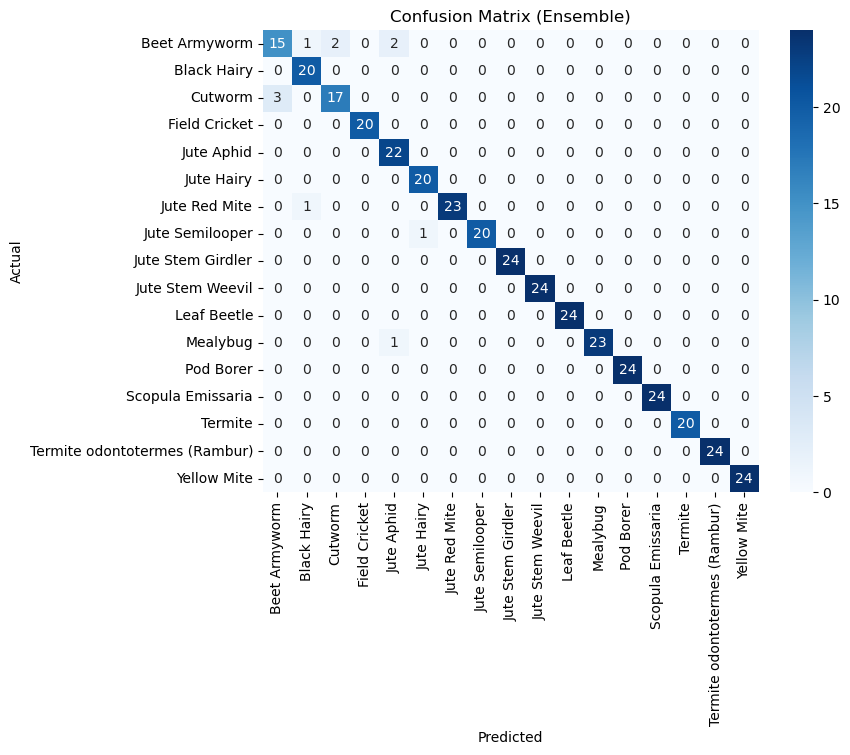

In [17]:
# === STEP 1: DATA PREPROCESSING ===
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=train_transforms)
val_dataset = ImageFolder(root=f"{dataset_path}/val", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# === STEP 2: MODEL DEFINITIONS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Custom CNN Model (corrected to output raw logits)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 1024 * 1 * 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Raw logits

# ResNet18 Model
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Instantiate models
custom_model = CustomCNN(num_classes).to(device)
resnet_model = resnet_model.to(device)

# === LOAD TRAINED MODELS ===
custom_model.load_state_dict(torch.load("Models/3.pth"))
resnet_model.load_state_dict(torch.load("Models/1.pth"))
custom_model.eval()
resnet_model.eval()

# === DEFINE AND SAVE ENSEMBLE MODEL ===
class EnsembleModel(nn.Module):
    def __init__(self, custom_model, resnet_model):
        super(EnsembleModel, self).__init__()
        self.custom_model = custom_model
        self.resnet_model = resnet_model

    def forward(self, x):
        outputs_custom = self.custom_model(x)
        outputs_resnet = self.resnet_model(x)
        probs_custom = F.softmax(outputs_custom, dim=1)
        probs_resnet = F.softmax(outputs_resnet, dim=1)
        avg_probs = (probs_custom + probs_resnet) / 2
        return avg_probs

# Create the ensemble model
ensemble_model = EnsembleModel(custom_model, resnet_model)

# Save the ensemble model using TorchScript
scripted_ensemble = torch.jit.script(ensemble_model)
scripted_ensemble.save("ensemble_model.pt")
print("Ensemble model saved as 'ensemble_model.pt'")

# === STEP 4: ENSEMBLE TESTING ===
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Use the ensemble model directly
        avg_probs = ensemble_model(images)
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nEnsemble Test Accuracy: {test_acc:.2f}%")

class_names = train_dataset.classes
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ensemble)")
plt.show()

#### Using the Saved Ensemble Model Later

In [18]:
# Define the same transforms used during testing
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load your test dataset
dataset_path = "Jute_Pest_Dataset"  # Change this to your dataset path
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the saved ensemble model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_ensemble = torch.jit.load("ensemble_model.pt")
loaded_ensemble = loaded_ensemble.to(device)
loaded_ensemble.eval()

# Perform inference
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        avg_probs = loaded_ensemble(images)  # Get averaged probabilities
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"Loaded Ensemble Test Accuracy: {test_acc:.2f}%")

Loaded Ensemble Test Accuracy: 97.10%


# Integrating the two ensembeled models(balaneced & imbalanced dataset)

Super ensemble model saved as 'super_ensemble_model.pt'

Super Ensemble Test Accuracy: 97.89%

Classification Report:

                               precision    recall  f1-score   support

                Beet Armyworm       0.89      0.85      0.87        20
                  Black Hairy       0.95      1.00      0.98        20
                      Cutworm       0.95      0.90      0.92        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.92      1.00      0.96        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
                     Mealybu

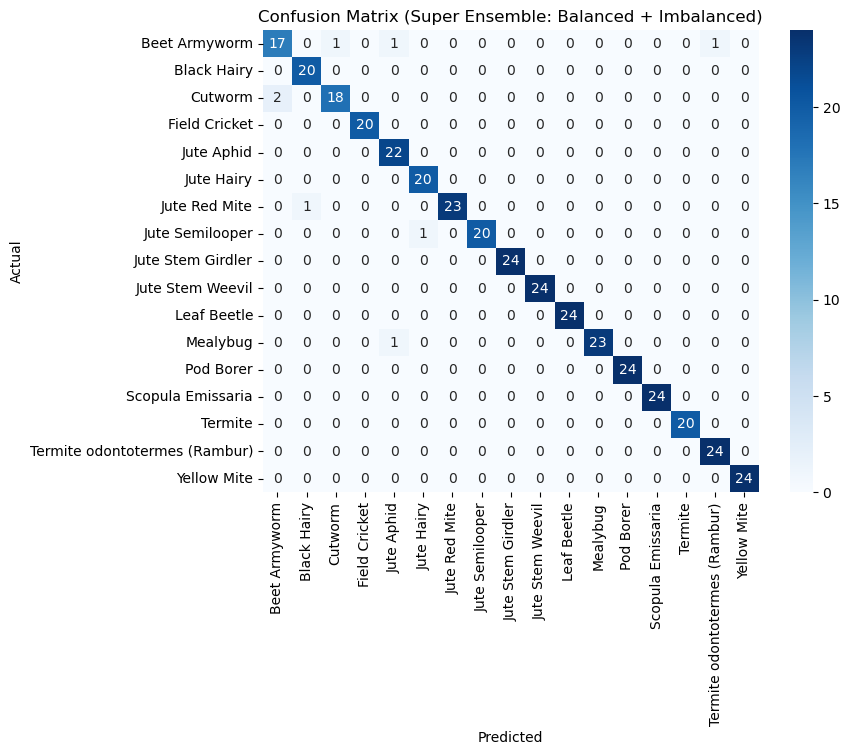

In [ ]:
# === STEP 1: DATA PREPROCESSING ===
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Use the absolute path to the dataset (update as needed)
dataset_path = "D:/Telegram Downloads/Old Materials/Fourth Year First Term/Neural Networks and Deep Learning/Jute_Pest_Notebooks/NoteBook 2/Jute_Pest_Dataset"
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# === STEP 2: LOAD THE TWO ENSEMBLE MODELS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ensemble trained on the balanced dataset
ensemble_balanced = torch.jit.load("ensemble_model.pt")
ensemble_balanced = ensemble_balanced.to(device)
ensemble_balanced.eval()

# Load the ensemble trained on the imbalanced dataset
ensemble_imbalanced_path = os.path.join("..", "NoteBook 1", "ensemble_model.pt")
ensemble_imbalanced = torch.jit.load(ensemble_imbalanced_path)
ensemble_imbalanced = ensemble_imbalanced.to(device)
ensemble_imbalanced.eval()

# === STEP 3: DEFINE THE SUPER ENSEMBLE MODEL ===
class SuperEnsembleModel(nn.Module):
    def __init__(self, ensemble_balanced, ensemble_imbalanced):
        super(SuperEnsembleModel, self).__init__()
        self.ensemble_balanced = ensemble_balanced
        self.ensemble_imbalanced = ensemble_imbalanced

    def forward(self, x):
        probs_balanced = self.ensemble_balanced(x)
        probs_imbalanced = self.ensemble_imbalanced(x)
        avg_probs = (probs_balanced + probs_imbalanced) / 2
        return avg_probs

# Create the super ensemble model
super_ensemble = SuperEnsembleModel(ensemble_balanced, ensemble_imbalanced)
super_ensemble = super_ensemble.to(device)

# Optionally, save the super ensemble model
scripted_super_ensemble = torch.jit.script(super_ensemble)
scripted_super_ensemble.save("super_ensemble_model.pt")
print("Super ensemble model saved as 'super_ensemble_model.pt'")

# === STEP 4: EVALUATE THE SUPER ENSEMBLE ===
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Get predictions from the super ensemble
        avg_probs = super_ensemble(images)
        _, predicted = torch.max(avg_probs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nSuper Ensemble Test Accuracy: {test_acc:.2f}%")

# Generate classification report
class_names = test_dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Super Ensemble: Balanced + Imbalanced)")
plt.show()

## Making predictions from balanced dataset(trasin, test) using the super ensemble model

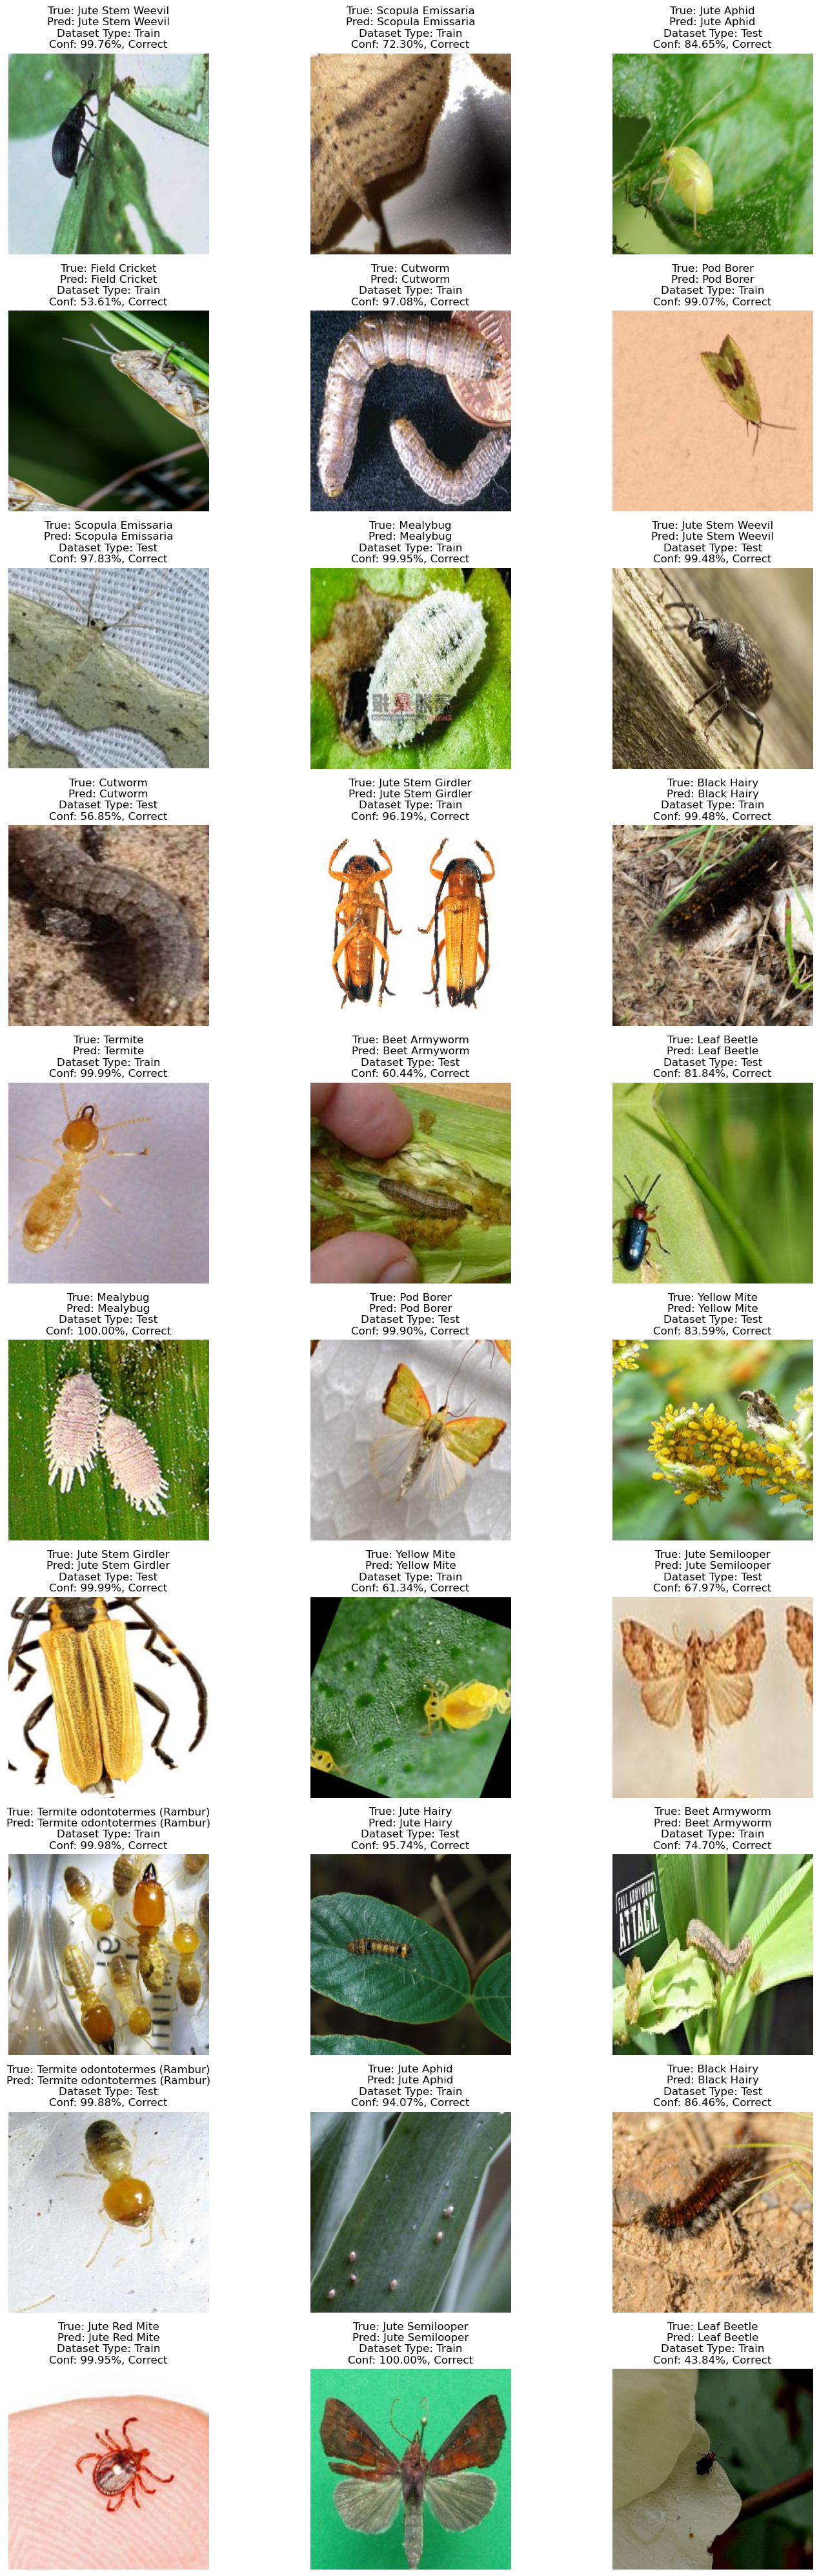

Images saved to: D:/Telegram Downloads/Old Materials/Fourth Year First Term/Neural Networks and Deep Learning/Jute_Pest_Notebooks/Predicted_Images


In [ ]:
# === STEP 1: DEFINE TRANSFORMATIONS ===
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# === STEP 2: LOAD THE DATASET AND MODEL ===
# Use the absolute path to the dataset
dataset_path = "D:/Telegram Downloads/Old Materials/Fourth Year First Term/Neural Networks and Deep Learning/Jute_Pest_Notebooks/NoteBook 1/Jute_Pest_Dataset"

# Load train and test datasets
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=val_test_transforms)
test_dataset = ImageFolder(root=f"{dataset_path}/test", transform=val_test_transforms)

# Load the super ensemble model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
super_ensemble = torch.jit.load("super_ensemble_model.pt")
super_ensemble = super_ensemble.to(device)
super_ensemble.eval()

# Get class names
class_names = train_dataset.classes

# === STEP 3: SELECT 30 RANDOM IMAGES ACROSS ALL CLASSES ===
def get_random_images(dataset, num_samples_per_class):
    class_to_images = {}
    for img_path, label in dataset.samples:
        class_name = class_names[label]
        if class_name not in class_to_images:
            class_to_images[class_name] = []
        class_to_images[class_name].append((img_path, class_name))
    
    selected_images = []
    for class_name in class_names:
        if class_to_images[class_name]:
            num_to_select = min(num_samples_per_class, len(class_to_images[class_name]))
            selected = random.sample(class_to_images[class_name], num_to_select)
            selected_images.extend(selected)
    
    return selected_images

# Calculate number of images to select per class to reach a total of 30
total_images = 30
num_classes = len(class_names)  # 17 classes
num_samples_per_class = max(1, total_images // (2 * num_classes))  # Divide by 2 because we have train and test

# Get random images from train and test
random.seed(42)  # For reproducibility
train_images = get_random_images(train_dataset, num_samples_per_class)
test_images = get_random_images(test_dataset, num_samples_per_class)

# Combine and ensure we have exactly 30 images
all_images = train_images + test_images
if len(all_images) > total_images:
    all_images = random.sample(all_images, total_images)
elif len(all_images) < total_images:
    # If we have fewer than 30 images, adjust by adding more from remaining classes
    remaining = total_images - len(all_images)
    additional_images = get_random_images(train_dataset, 1) + get_random_images(test_dataset, 1)
    all_images.extend(random.sample(additional_images, min(remaining, len(additional_images))))

# === STEP 4: MAKE PREDICTIONS AND DISPLAY IN A GRID ===
# Create a grid of 10 rows x 3 columns (for 30 images)
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 40))
axes = axes.flatten()

# Create output folder to save images
output_folder = "D:/Telegram Downloads/Old Materials/Fourth Year First Term/Neural Networks and Deep Learning/Jute_Pest_Notebooks/Predicted_Images"
os.makedirs(output_folder, exist_ok=True)

for idx, (image_path, true_class) in enumerate(all_images):
    # Extract filename from the path
    image_filename = os.path.basename(image_path)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = val_test_transforms(image).unsqueeze(0).to(device)

    # Get probabilities from the model
    with torch.no_grad():
        probs = super_ensemble(image_tensor)

    # Get predicted class and confidence
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][predicted_class_idx].item()
    predicted_class = class_names[predicted_class_idx]
    is_correct = "Correct" if predicted_class == true_class else "Incorrect"

    # Display results in the console
    dataset_type = "Train" if "train" in image_path.lower() else "Test"

    # Display the image in the grid
    ax = axes[idx]
    ax.imshow(image)
    ax.set_title(f"True: {true_class}\nPred: {predicted_class}\nDataset Type: {dataset_type}\nConf: {confidence * 100:.2f}%, {is_correct}")
    ax.axis("off")

    # Save the image to the output folder
    output_path = os.path.join(output_folder, f"{idx+1}_{image_filename}")
    shutil.copy(image_path, output_path)

# Adjust layout and display the grid
plt.tight_layout()
plt.show()

print(f"Images saved to: {output_folder}")